## Overview

This notebook validates that an autoencoder can be built, and the CNN features can be re-used in a classifier.

The code is fairly tightly coupled to the [MRLEyeDataset](http://mrl.cs.vsb.cz/eyedataset), but could be generalized to other datasets.

## Python imports

In [1]:
import torch
from torch import nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
import torchvision.transforms as T
from torchvision.io import read_image
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
import torch.nn.functional as F
from torchmetrics.classification import BinaryAccuracy
from sklearn.model_selection import StratifiedShuffleSplit
import torchvision
import wandb

## Define constants

In [2]:
square_image_size = 82
batch_size = 128
use_linear_autoencoder = False

## Initialization

In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
wandb.login()

Using device: cuda


wandb: Currently logged in as: tleyden (eyepi). Use `wandb login --relogin` to force relogin


True

## Define custom dataset and data loader

In [4]:
class MRLEyeDataset(Dataset):
    def __init__(self, annotations_file_or_df, img_dir, transform=None):
        
        if isinstance(annotations_file_or_df, str):
            self.img_labels = pd.read_csv(annotations_file_or_df)
        elif isinstance(annotations_file_or_df, pd.DataFrame):
            self.img_labels = annotations_file_or_df
        else:
            raise Exception(f"Unexpected object type: {self.img_labels}")
            
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        
        # TODO: put tensors on device here
        
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        
        #image = read_image(img_path)
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label, img_path
    
class MRLEyeDatasetTiny(MRLEyeDataset):
    def __len__(self):
        return len(self.img_labels) // 20  # Use smaller dataset to try to overfit on a small subset of the dataset
    

## Split into train / validation

In [6]:

# Labels csv is generated by GenerateDatasetLabels.ipynb
raw_df = pd.read_csv("labels.csv")

Xs = raw_df.drop(columns=['label'])
ys = raw_df.filter(items=['label'])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

train_index, validation_index = next(sss.split(Xs, ys))

# Reassemble training and validation dataframes that contain both labels and images
train_subset_df = raw_df.iloc[train_index]
validation_df = raw_df.iloc[validation_index]



## Create data loader instances

In [7]:
transform = transforms.Compose([
    T.Resize((square_image_size,square_image_size)),
    T.ToTensor()
])
mrleye_full_dataset = MRLEyeDataset(
    annotations_file_or_df=raw_df,
    img_dir=".",
    transform=transform
)
mrleye_train_dataset = MRLEyeDataset(
    annotations_file_or_df=train_subset_df,
    img_dir=".",
    transform=transform
)
mrleye_validation_dataset = MRLEyeDataset(
    annotations_file_or_df=validation_df,
    img_dir=".",
    transform=transform
)

mrleye_tiny = MRLEyeDatasetTiny(
    annotations_file_or_df="labels.csv", 
    img_dir=".",
    transform=transform
)

In [8]:
data_loader_full = DataLoader(
    dataset=mrleye_full_dataset,
    batch_size=batch_size,
    shuffle=True
)
data_loader_train = DataLoader(
    dataset=mrleye_train_dataset,
    batch_size=batch_size,
    shuffle=True
)
data_loader_validation = DataLoader(
    dataset=mrleye_validation_dataset,
    batch_size=batch_size,
    shuffle=True
)
data_loader_tiny = DataLoader(
    dataset=mrleye_tiny,
    batch_size=batch_size,
    shuffle=True
)

## Define autoencoder CNN model

Results after training 5 epochs.  See above for explanation of this image grid.

![Screen Shot 2023-01-10 at 7 14 27 PM](https://user-images.githubusercontent.com/296876/211709562-d680bf32-bf97-4caf-9aca-ef28578e9634.png)


In [10]:

def create_encoder():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=2)
    )

class Autoencoder(nn.Module):
    """
    CNN autoencoder
    """
    def __init__(self):
        super().__init__()        
        self.encoder = create_encoder()
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
model = Autoencoder().to(device)
model_summary = summary(model, input_size=(1, square_image_size, square_image_size))
print(model_summary)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 41, 41]             160
              ReLU-2           [-1, 16, 41, 41]               0
            Conv2d-3           [-1, 32, 21, 21]           4,640
              ReLU-4           [-1, 32, 21, 21]               0
            Conv2d-5             [-1, 64, 8, 8]         100,416
   ConvTranspose2d-6           [-1, 32, 21, 21]         100,384
              ReLU-7           [-1, 32, 21, 21]               0
   ConvTranspose2d-8           [-1, 16, 41, 41]           4,624
              ReLU-9           [-1, 16, 41, 41]               0
  ConvTranspose2d-10            [-1, 1, 82, 82]             145
          Sigmoid-11            [-1, 1, 82, 82]               0
Total params: 210,369
Trainable params: 210,369
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/

## Define optimizer and loss function

In [11]:
# Compare L1 loss - torch.L1Loss() (abs value)
criterion = nn.MSELoss()

learning_rate_autoencoder = 1e-3
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate_autoencoder, 
                             weight_decay=1e-5)

## Training loop

In [12]:
num_epochs = 5

data_loader = data_loader_full

wandb_config = {
  "learning_rate": learning_rate_autoencoder,
  "architecture": "CNNAutoencoder",
  "dataset": "MRL",
  "dataset_size": len(data_loader),
  "loss_fn": criterion,
  "epochs": num_epochs,
  "model_summary": model_summary
}

wandb.init(
  # Use team
  entity="eyepi",
  # Set the project where this run will be logged
  project="YouthEyeHealth", 
  # Track hyperparameters and run metadata
  config=wandb_config
)

outputs = []
for epoch in range(num_epochs):
    for (img, _, _) in tqdm(data_loader):

        # put on gpu if avail
        img = img.to(device)
        
        if use_linear_autoencoder:
            img = img.reshape(-1, square_image_size*square_image_size)
        
        recon = model(img).to(device)
        
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    wandb.log({"epoch": epoch+1, "loss": loss.item()})
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    print(f"appending to outputs: img with shape {img.shape} and reconstructed image with shape {recon.shape}")
    outputs.append((epoch, img, recon))
    
wandb.finish()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 664/664 [00:34<00:00, 18.99it/s]


Epoch:1, Loss:0.0003
appending to outputs: img with shape torch.Size([34, 1, 82, 82]) and reconstructed image with shape torch.Size([34, 1, 82, 82])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 664/664 [00:34<00:00, 19.03it/s]


Epoch:2, Loss:0.0002
appending to outputs: img with shape torch.Size([34, 1, 82, 82]) and reconstructed image with shape torch.Size([34, 1, 82, 82])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 664/664 [00:34<00:00, 19.02it/s]


Epoch:3, Loss:0.0002
appending to outputs: img with shape torch.Size([34, 1, 82, 82]) and reconstructed image with shape torch.Size([34, 1, 82, 82])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 664/664 [00:34<00:00, 19.07it/s]


Epoch:4, Loss:0.0003
appending to outputs: img with shape torch.Size([34, 1, 82, 82]) and reconstructed image with shape torch.Size([34, 1, 82, 82])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 664/664 [00:34<00:00, 19.16it/s]

Epoch:5, Loss:0.0002
appending to outputs: img with shape torch.Size([34, 1, 82, 82]) and reconstructed image with shape torch.Size([34, 1, 82, 82])


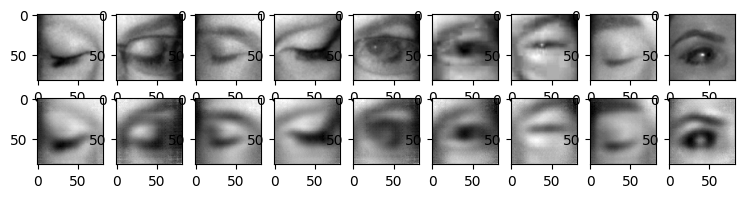

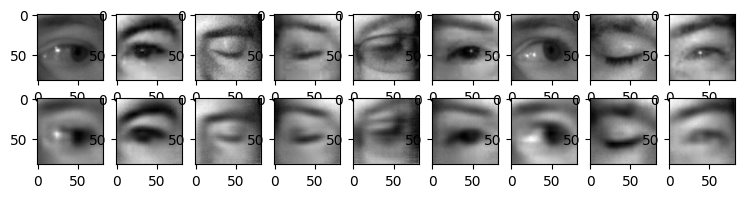

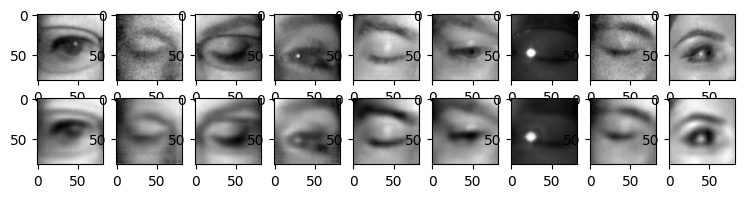

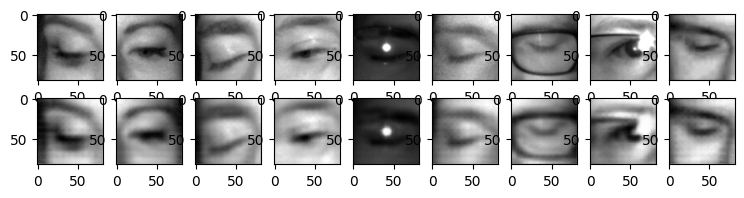

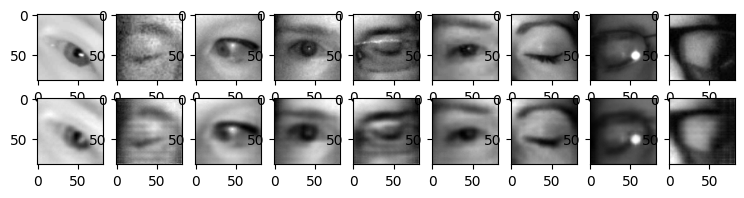

In [13]:
for k in range(0, len(outputs)):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        if use_linear_autoencoder:
            item = item.reshape(-1, square_image_size, square_image_size)
        # item: 1, 28, 28
        plt.imshow(item[0])
            
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        if use_linear_autoencoder:
            item = item.reshape(-1, square_image_size, square_image_size)
        # item: 1, 28, 28
        plt.imshow(item[0])

## Save model weights to file

In [14]:
torch.save(model.state_dict(), "autoencoder.pt")

## Build eyes open vs closed classifier based on CNN feature embeddings

1. Define a new model EyeOpenClosed that has the following changes:
    1. Remove conv2d transpose layers (decoder)
    1. Add fully connected layers that go down to a layer with two outputs
    1. Add softmax layer
1. Copy the encoder weights from the trained autoencoder model to the EyeOpenClosed model
1. Freeze the conv2d layers in the EyeOpenClosed instance so they are not updated during training (only fully connected layers)
1. Train this new model on labeled data


### Define EyeOpenClosed model

In [15]:
class EyeOpenClosed(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = self.encoder = create_encoder()
        
        # To address underfitting:
        #  - Add layer
        #  - Make layer wider
        
        self.fc1 = nn.Linear(64*8*8, 512)  # A little too large, hard to optimize
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)
        
    def forward(self, x):
        encoded = self.encoder(x)
                
        # At this point the shape will be [batch_size, 64, 15, 15], and we flatten it
        # into [batch_size, 14400])
        y = encoded.reshape(encoded.shape[0], -1)
                
        y =  F.relu(self.fc1(y))
        y =  F.relu(self.fc2(y))        
        y =  torch.sigmoid(self.fc3(y))

        
        return y

In [21]:
model_eoc = EyeOpenClosed().to(device)
model_summary = summary(model_eoc, input_size=(1, square_image_size, square_image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 41, 41]             160
              ReLU-2           [-1, 16, 41, 41]               0
            Conv2d-3           [-1, 32, 21, 21]           4,640
              ReLU-4           [-1, 32, 21, 21]               0
            Conv2d-5             [-1, 64, 8, 8]         100,416
            Linear-6                  [-1, 512]       2,097,664
            Linear-7                  [-1, 128]          65,664
            Linear-8                    [-1, 1]             129
Total params: 2,268,673
Trainable params: 2,268,673
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.66
Params size (MB): 8.65
Estimated Total Size (MB): 9.34
----------------------------------------------------------------


### Copy the encoder weights from the trained autoencoder model to the EyeOpenClosed modelprint("Model's state_dict:")

In [22]:
# Load the state dict with strict = false

missing_keys, unexpected_keys = model_eoc.load_state_dict(model.state_dict(), strict=False)

print(f"missing_keys: {missing_keys}")
print(f"unexpected_keys: {unexpected_keys}")

# Make sure the eoc model contains the expected weights
assert torch.equal(model.state_dict()["encoder.0.weight"], model_eoc.state_dict()["encoder.0.weight"])

# Dump state dictionaries

print("Pretrained model's state_dict:\n")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("\n----------- \n")

print("Eye open closed model's state_dict:\n")
for param_tensor in model_eoc.state_dict():
    print(param_tensor, "\t", model_eoc.state_dict()[param_tensor].size())

missing_keys: ['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']
unexpected_keys: ['decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.4.weight', 'decoder.4.bias']
Pretrained model's state_dict:

encoder.0.weight 	 torch.Size([16, 1, 3, 3])
encoder.0.bias 	 torch.Size([16])
encoder.2.weight 	 torch.Size([32, 16, 3, 3])
encoder.2.bias 	 torch.Size([32])
encoder.4.weight 	 torch.Size([64, 32, 7, 7])
encoder.4.bias 	 torch.Size([64])
decoder.0.weight 	 torch.Size([64, 32, 7, 7])
decoder.0.bias 	 torch.Size([32])
decoder.2.weight 	 torch.Size([32, 16, 3, 3])
decoder.2.bias 	 torch.Size([16])
decoder.4.weight 	 torch.Size([16, 1, 3, 3])
decoder.4.bias 	 torch.Size([1])

----------- 

Eye open closed model's state_dict:

encoder.0.weight 	 torch.Size([16, 1, 3, 3])
encoder.0.bias 	 torch.Size([16])
encoder.2.weight 	 torch.Size([32, 16, 3, 3])
encoder.2.bias 	 torch.Size([32])
encoder.4.weight 	 torch.Size([64, 32, 7, 7])
encoder.4

### Freeze the encoder conv2d layers in the EyeOpenClosed instance so they are not updated during training (only fully connected layers)

In [23]:
for name, param in model_eoc.named_parameters():
    if name.startswith("encoder"):
        param.requires_grad = False
        
for name, param in model_eoc.named_parameters():
    print(f"Param {name} requires gradient: {param.requires_grad}")

Param encoder.0.weight requires gradient: False
Param encoder.0.bias requires gradient: False
Param encoder.2.weight requires gradient: False
Param encoder.2.bias requires gradient: False
Param encoder.4.weight requires gradient: False
Param encoder.4.bias requires gradient: False
Param fc1.weight requires gradient: True
Param fc1.bias requires gradient: True
Param fc2.weight requires gradient: True
Param fc2.bias requires gradient: True
Param fc3.weight requires gradient: True
Param fc3.bias requires gradient: True


### Define optimizer and loss function

In [24]:
criterion = nn.BCELoss()

# TODO: learning rate scheduler - every 10 epochs, reduce the learning rate.  Pytorch optimizer takes a LR scheduler.

learning_rate_classifier = 1e-3
optimizer = torch.optim.Adam(model_eoc.parameters(),
                             lr=learning_rate_classifier, 
                             weight_decay=1e-5)  # TODO: read up on weight decay

### Train this new model on labeled data

In [25]:
num_epochs = 5

wandb_config = {
  "learning_rate": learning_rate_classifier,
  "architecture": "Classifier",
  "dataset": "MRL",
  "dataset_size_train": len(data_loader_train),
  "loss_fn": criterion,
  "epochs": num_epochs,
  "model_summary": model_summary
}

wandb.init(
  # Use team
  entity="eyepi",
  # Set the project where this run will be logged
  project="YouthEyeHealth", 
  # Track hyperparameters and run metadata
  config=wandb_config
)

outputs = []

metric_accuracy = BinaryAccuracy().to(device)

for epoch in range(num_epochs):
    
    accuracy_readings = []
    
    for (img, label, img_path) in tqdm(data_loader_train):
        
        # Put on gpu if avail
        # ToDevice trick: if data loader is on gpu
        img = img.to(device)
        label = label.to(device)
        
        # Get predictions from model
        y_pred = model_eoc(img)
        
        # Put on gpu if avail - won't be needed after changing data loader and model     
        y_pred = y_pred.to(device)
        
        # Reshape y_pred from torch.Size([128, 1]) -> torch.Size([128])
        y_pred = y_pred.reshape(-1)
        
        # Convert from long ints -> floats (note: this conversion could also be done in dataloader instead)
        label = label.float()
        
        # Compute loss
        loss = criterion(y_pred, label)
        
        # Compute accuracy
        # TODO: might not be correct.  last batch is not same size.
        # TODO: put y_pred back on cpu
        accuracy_readings.append(metric_accuracy(y_pred, label))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Train accuracy
    avg_accuracy = torch.mean(torch.tensor(accuracy_readings))
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.5f} Accuracy:{avg_accuracy.item():.5f}')
    
    # Validation set accuracy 
    with torch.no_grad():
        
        accuracy_readings = []
        for (img, label, img_path) in tqdm(data_loader_validation):
            
            # Put on gpu if avail
            img = img.to(device)
            label = label.to(device)

            # Get predictions from model
            y_pred = model_eoc(img)

            # Put on gpu if avail        
            y_pred = y_pred.to(device)

            # Reshape y_pred from torch.Size([128, 1]) -> torch.Size([128])
            y_pred = y_pred.reshape(-1)

            # Convert from long ints -> floats (note: this conversion could also be done in dataloader instead)
            label = label.float()
            
            # TODO: Compute validation loss
           
            # Compute validation accuracy
            accuracy_readings.append(metric_accuracy(y_pred, label))
            
        avg_accuracy = torch.mean(torch.tensor(accuracy_readings))
        print(f'Validation Accuracy:{avg_accuracy.item():.5f}')
        
wandb.finish()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 531/531 [00:27<00:00, 18.97it/s]


Epoch:1, Loss:0.13943 Accuracy:0.92871


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:06<00:00, 19.20it/s]


Validation Accuracy:0.96025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 531/531 [00:28<00:00, 18.83it/s]


Epoch:2, Loss:0.10471 Accuracy:0.96034


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:06<00:00, 19.31it/s]


Validation Accuracy:0.95614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 531/531 [00:28<00:00, 18.88it/s]


Epoch:3, Loss:0.09171 Accuracy:0.96822


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:06<00:00, 19.20it/s]


Validation Accuracy:0.97303


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 531/531 [00:28<00:00, 18.86it/s]


Epoch:4, Loss:0.05076 Accuracy:0.97150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:06<00:00, 19.46it/s]


Validation Accuracy:0.97515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 531/531 [00:27<00:00, 18.97it/s]


Epoch:5, Loss:0.06788 Accuracy:0.97310


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 133/133 [00:06<00:00, 19.45it/s]

Validation Accuracy:0.97060


### Examine results (successful and failed predictions)

In [36]:
data_iter = iter(data_loader_validation)
images, labels, image_paths = next(data_iter)

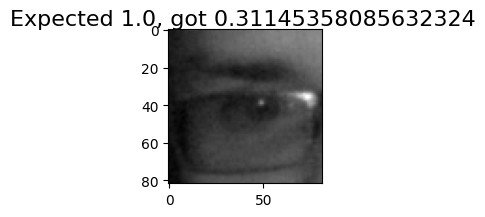

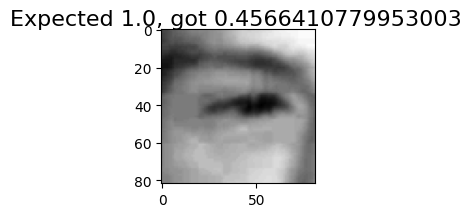

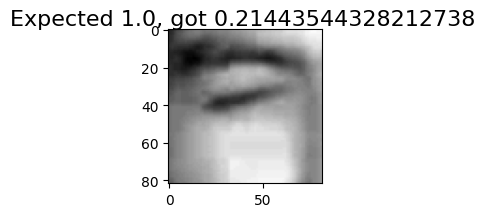

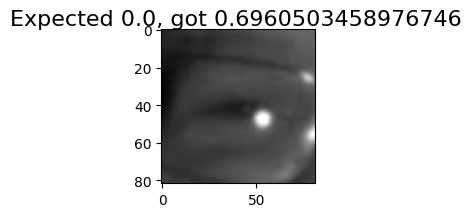

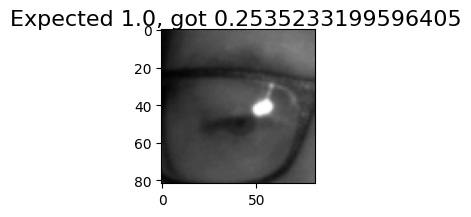

In [37]:
metric_accuracy = BinaryAccuracy().to(device)
for i, image in enumerate(images):
    image = image.to(device)
    image_in_batch = image.unsqueeze(dim=0)
    label = labels[i].to(device)
    label = label.unsqueeze(dim=0)
    image_path = image_paths[i]
    y_pred = model_eoc(image_in_batch)
    
    # Reshape y_pred from torch.Size([batch_size, 1]) -> torch.Size([batch_size])
    y_pred = y_pred.reshape(-1)
    
    # Convert from long ints -> floats (note: this conversion could also be done in dataloader instead)
    label = label.float()
    
    image_to_display = torchvision.transforms.ToPILImage()(image)
    
    if metric_accuracy(y_pred, label) == 1.0:
        #print(f"y_pred {y_pred} matches label {label}")
        # fig = plt.figure(figsize=(2,2))
        # fig.suptitle(f'Got expected {label.item()}: {y_pred.item()}', fontsize=16)
        # plt.imshow(image_to_display)
        pass
    else:
        #print(f"y_pred {y_pred} does not match label {label}")
        fig = plt.figure(figsize=(2,2))
        fig.suptitle(f'Expected {label.item()}, got {y_pred.item()}', fontsize=16)
        plt.imshow(image_to_display)
        #pass